In [207]:
import tensorflow as tf
import pandas as pd
import numpy as np
import time
from math import sqrt
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from utils.confusion_matrix import show_confusion_matrix

In [208]:
# data = pd.read_csv("simulate-circle.csv",header=0)
data = pd.read_csv("simulate-police.csv",header=0)

In [209]:
data = data.drop(['x11','x12','x3','x4','x5','x6','x7','x8','x9','x10'], axis=1)

In [210]:
data.head()

,x1,x2,y
0,2.151302,1.261139,1
1,-0.115938,1.591839,0
2,1.108706,-0.060229,1
3,-2.637907,-0.257359,1
4,-0.104738,1.995355,0


In [211]:
xdata = data.drop('y', axis=1)
ydata = data[['y']]
xtrain, xtest, ytrain, ytest = train_test_split(xdata, ydata, test_size=0.3, random_state=42)

In [212]:
# split = int(len(ytest)/2)
split=0.2*len(ydata)
xvalid = xtest[:split]
yvalid = ytest[:split]
xtest = xtest[split:]
ytest = ytest[split:]

In [213]:
print(xtrain.shape)
print(ytrain.shape)
print(xvalid.shape)
print(yvalid.shape)
print(xtest.shape)
print(ytest.shape)

(6000, 2)
(6000, 1)
(2000, 2)
(2000, 1)
(2000, 2)
(2000, 1)


In [214]:
xtrain = xtrain.as_matrix()
xtest = xtest.as_matrix()
ytrain = ytrain.as_matrix()
ytest = ytest.as_matrix()
xvalid = xvalid.as_matrix()
yvalid = yvalid.as_matrix()

In [215]:
f=open('cs-training.csv','w')
for i,j in enumerate(xtrain):
    k=np.append(np.array(ytrain[i]),j   )
    f.write(",".join([str(s) for s in k]) + '\n')
f.close()

f=open('cs-testing.csv','w')
for i,j in enumerate(xtest):
    k=np.append(np.array(ytest[i]),j   )
    f.write(",".join([str(s) for s in k]) + '\n')
f.close()

f=open('cs-validation.csv','w')
for i,j in enumerate(xvalid):
    k=np.append(np.array(yvalid[i]),j   )
    f.write(",".join([str(s) for s in k]) + '\n')
f.close()

In [216]:
def convertOneHot(data):
    y=np.array([int(i[0]) for i in data])
    y_onehot=[0]*len(y)
    for i,j in enumerate(y):
        y_onehot[i]=[0]*(y.max() + 1)
        y_onehot[i][j]=1
    return (y,y_onehot)

In [217]:
data = np.genfromtxt('cs-training.csv',delimiter=',')  # Training data
test_data = np.genfromtxt('cs-testing.csv',delimiter=',')  # Test data
valid_data = np.genfromtxt('cs-validation.csv',delimiter=',')  # Test data

xtrain=np.array([ i[1::] for i in data])
ytrain,ytrain_onehot = convertOneHot(data)

xtest=np.array([ i[1::] for i in test_data])
ytest,ytest_onehot = convertOneHot(test_data)

xvalid=np.array([ i[1::] for i in valid_data])
yvalid,yvalid_onehot = convertOneHot(valid_data)

In [218]:
yvalid_onehot = np.asarray(yvalid_onehot)
ytrain_onehot = np.asarray(ytrain_onehot)
ytest_onehot = np.asarray(ytest_onehot)

In [219]:
input_nodes = xtrain.shape[1]

mulitplier = 1.5 

hidden_nodes1 = 8
hidden_nodes2 = 8
hidden_nodes3 = 8
hidden_nodes4 = 8

# hidden_nodes2 = round(hidden_nodes1 * mulitplier)
# hidden_nodes3 = round(hidden_nodes2 * mulitplier)

pkeep = tf.placeholder(tf.float32)

In [220]:
# input
x = tf.placeholder(tf.float32, [None, input_nodes])

# layer 1
W1 = tf.Variable(tf.truncated_normal([input_nodes, hidden_nodes1], stddev = sqrt(2/input_nodes)))
b1 = tf.Variable(tf.zeros([hidden_nodes1]))
y1 = tf.nn.sigmoid(tf.matmul(x, W1) + b1)

# layer 2
W2 = tf.Variable(tf.truncated_normal([hidden_nodes1, hidden_nodes2], stddev = sqrt(2/hidden_nodes1)))
b2 = tf.Variable(tf.zeros([hidden_nodes2]))
y2 = tf.nn.sigmoid(tf.matmul(y1, W2) + b2)

# layer 3
W3 = tf.Variable(tf.truncated_normal([hidden_nodes2, hidden_nodes3], stddev = sqrt(2/hidden_nodes2))) 
b3 = tf.Variable(tf.zeros([hidden_nodes3]))
y3 = tf.nn.sigmoid(tf.matmul(y2, W3) + b3)
y3 = tf.nn.dropout(y3, pkeep)

# layer 4
W4 = tf.Variable(tf.truncated_normal([hidden_nodes3, hidden_nodes4], stddev = sqrt(2/hidden_nodes3))) 
b4 = tf.Variable(tf.zeros([hidden_nodes4]))
y4 = tf.nn.sigmoid(tf.matmul(y3, W4) + b4)
y4 = tf.nn.dropout(y4, pkeep)

# layer 5
W5 = tf.Variable(tf.truncated_normal([hidden_nodes4, 2], stddev = sqrt(2/hidden_nodes4))) 
b5 = tf.Variable(tf.zeros([2]))
y5 = tf.nn.softmax(tf.matmul(y4, W5) + b5)

# output
y = y5
y_ = tf.placeholder(tf.float32, [None, 2])

In [221]:
# Parameters
training_epochs = 1000
training_dropout = 1
display_step = 10
n_samples = ytrain.shape[0]
batch_size = 32
learning_rate = 0.01

In [222]:
cost = -tf.reduce_sum(y_*tf.log(tf.clip_by_value(y,1e-10,1.0)))

optimizer = tf.train.AdamOptimizer(learning_rate).minimize(cost)

correct_prediction = tf.equal(tf.argmax(y,1), tf.argmax(y_,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

pred_tensor = tf.cast(tf.argmax(y_, 1),tf.float32)
y_tensor = tf.cast(tf.argmax(y,1),tf.float32)
auc = tf.contrib.metrics.streaming_auc(y_tensor, pred_tensor)

In [223]:
accuracy_summary = [] 
cost_summary = [] 
auc_summary = []
valid_accuracy_summary = [] 
valid_cost_summary = [] 
valid_auc_summary = []
stop_early = 0

checkpoint = "checkpoint/best_model.ckpt"
saver = tf.train.Saver(max_to_keep=1)

In [224]:
start_time = time.time()
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    
    for epoch in range(training_epochs): 
        for batch in range(int(n_samples/batch_size)):
            batch_x = xtrain[batch*batch_size : (1+batch)*batch_size]
            batch_y = ytrain_onehot[batch*batch_size : (1+batch)*batch_size]

            sess.run([optimizer], feed_dict={x: batch_x, 
                                             y_: batch_y,
                                             pkeep: training_dropout})

        if (epoch) % display_step == 0:
            train_accuracy, newCost = sess.run([accuracy, cost], feed_dict={x: xtrain, 
                                                                            y_: ytrain_onehot,
                                                                            pkeep: training_dropout})

            valid_accuracy, valid_newCost = sess.run([accuracy, cost], feed_dict={x: xvalid, 
                                                                                  y_: yvalid_onehot,
                                                                                  pkeep: 1})

            print ("Epoch:", epoch,
                   " | Accuracy =", "{:.5f}".format(train_accuracy), 
                   " | Cost =", "{:.5f}".format(newCost),
                   " | Valid_Accuracy =", "{:.5f}".format(valid_accuracy), 
                   " | Valid_Cost = ", "{:.5f}".format(valid_newCost))
            
            accuracy_summary.append(train_accuracy)
            cost_summary.append(newCost)
            valid_accuracy_summary.append(valid_accuracy)
            valid_cost_summary.append(valid_newCost)
            
            if valid_accuracy <= max(valid_accuracy_summary) and epoch > 100:
                stop_early += 1
                if stop_early == 20:
                    break
            else:
                stop_early = 0
                saver.save(sess, checkpoint)
            
    print()
    print("Finished!")
    print("Execute time: %1.f seconds" % (time.time()-start_time))
    print()

Epoch: 0  | Accuracy = 0.58700  | Cost = 4129.24365  | Valid_Accuracy = 0.57400  | Valid_Cost =  1378.60522
Epoch: 10  | Accuracy = 0.79350  | Cost = 2251.58862  | Valid_Accuracy = 0.78200  | Valid_Cost =  774.86230
Epoch: 20  | Accuracy = 0.80767  | Cost = 1986.21094  | Valid_Accuracy = 0.79950  | Valid_Cost =  688.99054
Epoch: 30  | Accuracy = 0.91450  | Cost = 1164.16541  | Valid_Accuracy = 0.90350  | Valid_Cost =  413.81085
Epoch: 40  | Accuracy = 0.94933  | Cost = 747.33344  | Valid_Accuracy = 0.94450  | Valid_Cost =  263.88791
Epoch: 50  | Accuracy = 0.95900  | Cost = 628.99829  | Valid_Accuracy = 0.95400  | Valid_Cost =  218.59900
Epoch: 60  | Accuracy = 0.96167  | Cost = 571.24011  | Valid_Accuracy = 0.95950  | Valid_Cost =  199.49937
Epoch: 70  | Accuracy = 0.96333  | Cost = 531.01160  | Valid_Accuracy = 0.96100  | Valid_Cost =  186.54672
Epoch: 80  | Accuracy = 0.96500  | Cost = 497.74030  | Valid_Accuracy = 0.96400  | Valid_Cost =  175.74602
Epoch: 90  | Accuracy = 0.96767  

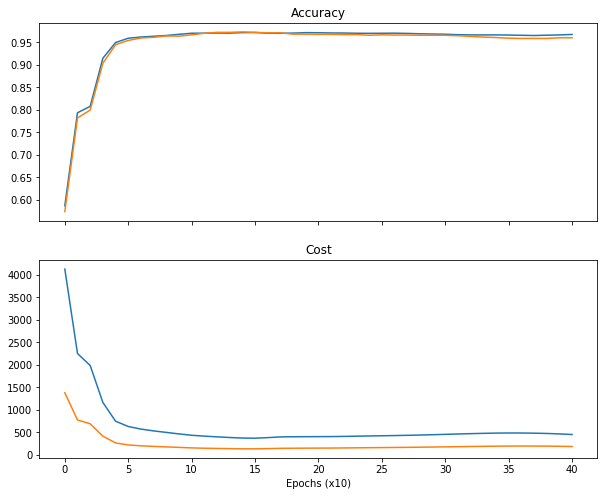

In [225]:
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(10,8))


ax1.plot(accuracy_summary)
ax1.plot(valid_accuracy_summary)
ax1.set_title('Accuracy')

ax2.plot(cost_summary)
ax2.plot(valid_cost_summary)
ax2.set_title('Cost')

plt.xlabel('Epochs (x10)')
plt.show()

INFO:tensorflow:Restoring parameters from checkpoint/best_model.ckpt
Accuracy : 0.9675
Precision: 0.96013864818
Recall   : 0.98314108252
F1       : 0.971503726436


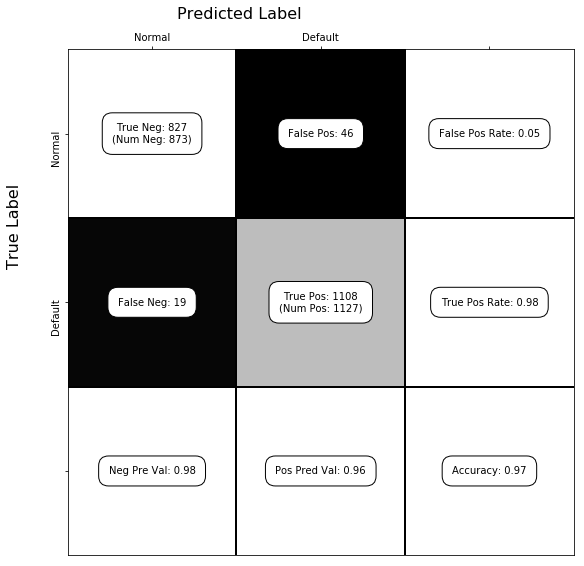

In [226]:
predicted = tf.argmax(y, 1)
with tf.Session() as sess:  
    saver.restore(sess, checkpoint)
    testing_predictions, testing_accuracy = sess.run([predicted, accuracy], 
                                                    feed_dict={x: xtest, y_:ytest_onehot, pkeep: 1})
    c = confusion_matrix(ytest_onehot[:,1], testing_predictions)
    show_confusion_matrix(c, ['Normal', 'Default'])

In [227]:
# output = {'Actual': ytest_onehot[:,1], 'Predicted': testing_predictions}
# df = pd.DataFrame(data=output)
# df.to_csv("output.csv", sep=',')